In [8]:
import pickle

hiragana = "ぁあぃいぅうぇえぉおかがきぎくぐけげこごさざしじすずせぜそぞ\
ただちぢっつづてでとどなにぬねのはばぱひびぴふぶぷへべぺほぼぽ\
まみむめもゃやゅゆょよらりるれろゎわゐゑをん"

katakana = "ァアィイゥウェエォオカガキギクグケゲコゴサザシジスズセゼソゾ\
タダチヂッツヅテデトドナニヌネノハバパヒビピフブプヘベペホボポ\
マミムメモャヤュユョヨラリルレロヮワヰヱヲンヴ"

chars = hiragana + katakana

with open("kana_kanji.txt", mode="r", encoding="utf-8") as f:
    text = f.read()
    
for char in text:
    if char not in chars:
        chars += char
        
chars += "\t\n"

chars_list = sorted(list(chars))
print(chars_list)

with open("kana_chars.pickle", mode="wb") as f:
    pickle.dump(chars_list, f)

['\t', '\n', '、', '。', '々', 'ぁ', 'あ', 'ぃ', 'い', 'ぅ', 'う', 'ぇ', 'え', 'ぉ', 'お', 'か', 'が', 'き', 'ぎ', 'く', 'ぐ', 'け', 'げ', 'こ', 'ご', 'さ', 'ざ', 'し', 'じ', 'す', 'ず', 'せ', 'ぜ', 'そ', 'ぞ', 'た', 'だ', 'ち', 'ぢ', 'っ', 'つ', 'づ', 'て', 'で', 'と', 'ど', 'な', 'に', 'ぬ', 'ね', 'の', 'は', 'ば', 'ぱ', 'ひ', 'び', 'ぴ', 'ふ', 'ぶ', 'ぷ', 'へ', 'べ', 'ぺ', 'ほ', 'ぼ', 'ぽ', 'ま', 'み', 'む', 'め', 'も', 'ゃ', 'や', 'ゅ', 'ゆ', 'ょ', 'よ', 'ら', 'り', 'る', 'れ', 'ろ', 'ゎ', 'わ', 'ゐ', 'ゑ', 'を', 'ん', 'ァ', 'ア', 'ィ', 'イ', 'ゥ', 'ウ', 'ェ', 'エ', 'ォ', 'オ', 'カ', 'ガ', 'キ', 'ギ', 'ク', 'グ', 'ケ', 'ゲ', 'コ', 'ゴ', 'サ', 'ザ', 'シ', 'ジ', 'ス', 'ズ', 'セ', 'ゼ', 'ソ', 'ゾ', 'タ', 'ダ', 'チ', 'ヂ', 'ッ', 'ツ', 'ヅ', 'テ', 'デ', 'ト', 'ド', 'ナ', 'ニ', 'ヌ', 'ネ', 'ノ', 'ハ', 'バ', 'パ', 'ヒ', 'ビ', 'ピ', 'フ', 'ブ', 'プ', 'ヘ', 'ベ', 'ペ', 'ホ', 'ボ', 'ポ', 'マ', 'ミ', 'ム', 'メ', 'モ', 'ャ', 'ヤ', 'ュ', 'ユ', 'ョ', 'ヨ', 'ラ', 'リ', 'ル', 'レ', 'ロ', 'ヮ', 'ワ', 'ヰ', 'ヱ', 'ヲ', 'ン', 'ヴ', '・', 'ー', '？']


In [9]:
import numpy as np

char_indices = {}
for i, char in enumerate(chars_list):
    char_indices[char] = i
indices_char = {}
for i, char in enumerate(chars_list):
    indices_char[i] = char
    
seperator="。"
sentence_list = text.split(seperator)
sentence_list.pop()
sentence_list = [x+seperator for x in sentence_list]

max_sentence_length = 128
sentence_list = [sentence for sentence in sentence_list if len(sentence) <= max_sentence_length]

n_char = len(chars_list)
n_sample = len(sentence_list) - 1

x_sentences = []
t_sentences = []
for i in range(n_sample):
    x_sentences.append(sentence_list[i])
    t_sentences.append("\t" + sentence_list[i+1] + "\n")
max_length_x = max_sentence_length
max_length_t = max_sentence_length + 2

x_encoder = np.zeros((n_sample, max_length_x, n_char), dtype=np.bool)
x_decoder = np.zeros((n_sample, max_length_t, n_char), dtype=np.bool)
t_decoder = np.zeros((n_sample, max_length_t, n_char), dtype=np.bool)

for i in range(n_sample):
    x_sentence = x_sentences[i]
    t_sentence = t_sentences[i]
    for j, char in enumerate(x_sentence):
        x_encoder[i, j, char_indices[char]] = 1
    for j, char in enumerate(t_sentence):
        x_decoder[i, j, char_indices[char]] = 1
        if j > 0:
            t_decoder[i, j-1, char_indices[char]] = 1
            
print(x_encoder.shape)

(5091, 128, 175)


In [10]:
batch_size = 32
epochs = 1000
n_mid = 256

In [11]:
from keras.models import Model
from keras.layers import Dense, GRU, Input, Masking

encoder_input = Input(shape=(None, n_char))
encoder_mask = Masking(mask_value=0)
encoder_masked = encoder_mask(encoder_input)
encoder_lstm = GRU(n_mid, dropout=0.2, recurrent_dropout=0.2, return_state=True)
encoder_output, encoder_state_h = encoder_lstm(encoder_masked)

decoder_input = Input(shape=(None, n_char))
decoder_mask = Masking(mask_value=0)
decoder_masked = encoder_mask(decoder_input)
decoder_lstm = GRU(n_mid, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, return_state=True)
decoder_output, _ = decoder_lstm(decoder_masked, initial_state=encoder_state_h)
decoder_dense = Dense(n_char, activation='softmax')
decoder_output = decoder_dense(decoder_output)

model = Model([encoder_input, decoder_input], decoder_output)

model.compile(loss="categorical_crossentropy", optimizer="rmsprop")
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, None, 175)    0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, None, 175)    0                                            
__________________________________________________________________________________________________
masking_5 (Masking)             (None, None, 175)    0           input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
gru_5 (GRU)                     [(None, 256), (None, 331776      masking_5[0][0]            

In [13]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor="val_loss", patience=10)

history = model.fit([x_encoder, x_decoder], t_decoder,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_split=0.1,
                   callbacks=[early_stopping])

Train on 4581 samples, validate on 510 samples
Epoch 1/1000
4581/4581 [==============================] - 148s 32ms/step - loss: 1.0510 - val_loss: 0.8758
Epoch 2/1000
4581/4581 [==============================] - 155s 34ms/step - loss: 0.8856 - val_loss: 0.8016
Epoch 3/1000
4581/4581 [==============================] - 150s 33ms/step - loss: 0.8378 - val_loss: 0.7781
Epoch 4/1000
4581/4581 [==============================] - 151s 33ms/step - loss: 0.8151 - val_loss: 0.7625
Epoch 5/1000
4581/4581 [==============================] - 151s 33ms/step - loss: 0.8022 - val_loss: 0.7506
Epoch 6/1000
4581/4581 [==============================] - 160s 35ms/step - loss: 0.7948 - val_loss: 0.7443
Epoch 7/1000
4581/4581 [==============================] - 159s 35ms/step - loss: 0.7925 - val_loss: 0.7367
Epoch 8/1000
4581/4581 [==============================] - 160s 35ms/step - loss: 0.7814 - val_loss: 0.7317
Epoch 9/1000
4581/4581 [==============================] - 161s 35ms/step - loss: 0.7778 - val_los

4581/4581 [==============================] - 156s 34ms/step - loss: 0.6473 - val_loss: 0.6354
Epoch 77/1000
4581/4581 [==============================] - 159s 35ms/step - loss: 0.6506 - val_loss: 0.6358
Epoch 78/1000
4581/4581 [==============================] - 159s 35ms/step - loss: 0.6402 - val_loss: 0.6345
Epoch 79/1000
4581/4581 [==============================] - 159s 35ms/step - loss: 0.6541 - val_loss: 0.6333
Epoch 80/1000
4581/4581 [==============================] - 160s 35ms/step - loss: 0.6456 - val_loss: 0.6346
Epoch 81/1000
4581/4581 [==============================] - 161s 35ms/step - loss: 0.6458 - val_loss: 0.6342
Epoch 82/1000
4581/4581 [==============================] - 159s 35ms/step - loss: 0.6615 - val_loss: 0.6347
Epoch 83/1000
4581/4581 [==============================] - 161s 35ms/step - loss: 0.6400 - val_loss: 0.6340
Epoch 84/1000
4581/4581 [==============================] - 161s 35ms/step - loss: 0.6466 - val_loss: 0.6345
Epoch 85/1000
4581/4581 [=================

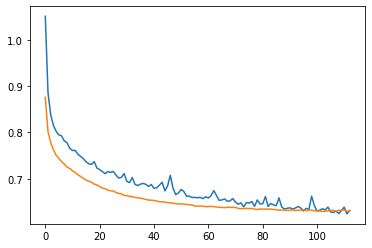

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(np.arange(len(loss)), loss)
plt.plot(np.arange(len(val_loss)), val_loss)
plt.show()

In [15]:
encoder_model = Model(encoder_input, encoder_state_h)

decoder_state_in_h = Input(shape=(n_mid,))
decoder_state_in = [decoder_state_in_h]

decoder_output, decoder_state_h = decoder_lstm(decoder_input,
                                              initial_state=decoder_state_in_h)
decoder_output = decoder_dense(decoder_output)

decoder_model = Model([decoder_input] + decoder_state_in,
                     [decoder_output, decoder_state_h])

encoder_model.save('encoder_model.h5')
decoder_model.save('decoder_model.h5')

In [21]:
def respond(input_data, beta=5):
    state_value = encoder_model.predict(input_data)
    y_decoder = np.zeros((1, 1, n_char))
    y_decoder[0][0][char_indices["\t"]] = 1
    
    respond_sentence = ""
    while True:
        y, h = decoder_model.predict([y_decoder, state_value])
        p_power = y[0][0] ** beta
        next_index = np.random.choice(len(p_power), p=p_power/np.sum(p_power))
        next_char = indices_char[next_index]
        
        if (next_char == "\n" or len(respond_sentence) >= max_length_x):
            break
            
        respond_sentence += next_char
        y_decoder = np.zeros((1, 1, n_char))
        y_decoder[0][0][next_index] = 1
        
        state_value = h
        
    return respond_sentence

In [22]:
for i in range(10):
    x_in = x_encoder[i:i+1]
    responce = respond(x_in)
    print("Input:", x_sentences[i])
    print("Response:", responce)
    print()

Input: ではみなさんは、そういうふうにかわだといわれたり、ちちのながれたあとだといわれたりしていたこのぼんやりとしろいものがほんとうはなにかごしょうちですか。
Response: いいね。

Input: せんせいは、こくばんにつるしたおおきなくろいせいざのずの、うえからしたへしろくけぶったぎんがおびのようなところをさしながら、みんなにとをかけました。
Response: そしてそのかわのみずをみていました。

Input: カムパネルラがてをあげました。
Response: それはもうだんだんうつくしいもんだ。

Input: それからしごにんてをあげました。
Response: そしてあんまりそっちをみていました。

Input: ジョバンニもてをあげようとして、いそいでそのままやめました。
Response: それからあのいちいうのはやくなっていました。

Input: たしかにあれがみんなほしだと、いつかざっしでよんだのでしたが、このごろはジョバンニはまるでまいにちきょうしつでもねむく、ほんをよむひまもよむほんもないので、なんだかどんなこともよくわからないというきもちがするのでした。
Response: そのときはこのつぎのにちのなかにはいっていました。

Input: ところがせんせいははやくもそれをみつけけたのでした。
Response: そしてそのときは、かたちになっていました。

Input: ジョバンニさん。
Response: あしたのはらにひかっていました。

Input: あなたはわかっているのでしょう。
Response: あのたまのかたちになりました。

Input: ジョバンニはせいよくたちあがりましたが、たってみるともうはっきりとそれをこたえることができないのでした。
Response: そしてそのつぎのにちもなくなっているのです。

